# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины (мД);
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [39]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 

import plotly.express as px # для построения графиков
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# модули машинного обучения
from sklearn.svm import OneClassSVM # Обнаружение аномалий
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict


from scipy.stats import shapiro # тест Шапиро-Уилка на нормальное распределение
from sklearn.pipeline import Pipeline

# В случае, если notebook не отображает графики plotly
# import plotly.io as pio
# pio.renderers.default = 'notebook'

Прочитаем исходные данные:

In [2]:
data = pd.read_csv(r'unconv.csv')
data.head()


,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


In [3]:
data.shape

(200, 8)

## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [4]:
# Ваш код здесь
feature_explanation={
    'Well': 'идентификатор скважины',
    'Por': 'пористость скважины (%)',
    'Perm': 'проницаемость скважины (мД)',
    'AI': 'акустический импеданс (кг/м^2 * 10^6)',
    'Brittle': 'коэффициент хрупкости скважины (%)',
    'TOC': 'общий органический углерод (%)',
    'VR': 'коэффициент отражения витринита (%)',
    'Prod': 'добыча газа в сутки (млн. кубических футов)'
}

# Отделение целевого признака из основной группы. Я отбросил признак 'Well' т.к. его можно заменить индексами
features = data.loc[0:, 'Por':'VR']
target = data['Prod']

# 1. Количество пропусков в данных
missed_values = data.isna().any().sum()
print(f'\nКоличество пропусков: {missed_values}')

# 2. Дубликаты в данных
count_duplicates = data.duplicated().sum()
print(f'Количество дубликатов: {count_duplicates}')

# 3. Распределение признаков (кроме целевого)
fig = make_subplots(rows=6,
                    cols=2
                    )
marker_colors = ('#4c72b0', '#55a868', '#c44e52', '#8172b2', '#ccb974', '#64b5cd')
annotations = []
y_coords = [0.86, 0.68, 0.50, 0.32, 0.14, -0.03]
for row in range(1,7):
    feature = features.columns[row-1]
    fig.add_trace(go.Histogram(x=features[feature],
                               name=feature,
                               showlegend=False,
                               marker_color=marker_colors[row-1]
                              ),
                  row=row,
                  col=2
                 )
    fig.add_trace(go.Box(x=features[feature],
                         name=feature,
                         boxmean=True,
                         marker_color=marker_colors[row-1]
                        ),
                  row=row,
                  col=1
                 )

    annotations.append(dict(
        text=feature_explanation[feature],
        x=0.5,  # центр между col=1 и col=2
        y=y_coords[row-1],  # позиция по оси Y
        xref='paper',
        yref='paper',
        showarrow=False,
        font=dict(size=12),
                       ))
        
fig.update_layout(height=1600,
                  title='Распределение признаков (кроме целевого)',
                  template='seaborn',
                  annotations=annotations)
fig.show()

# 4. Распредление целевого признака
px.histogram(target,
             title='Распредление целевого признака (Prod)',
             template='seaborn',
             labels={'value': feature_explanation['Prod']},
             height=500).show()


# 5. Обнаружение аномалий
# обнаружение аномалий с помощью квантилей
def outliers(feat):
    q3 = features[feat].quantile(0.75)
    q1 = features[feat].quantile(0.25)
    IQR =  q3 - q1
    lower = q1 - 1.5*IQR
    upper = q3 + 1.5*IQR
    rezult = features[(features[feat] < lower) | (features[feat] > upper)]
    return rezult[feat]
    
print('Обнаружение аномалий с помощью квантилей')
#индексы аномальных значений полученные с помощью квантилей
index_outliers_quntile = set()
count = 0
for feat in features.columns:
    outliers_series = outliers(feat)
    index_outliers_quntile.update(outliers_series.index)
    count += outliers_series.count()
print(f'Количество аномалий {count}')


# Обнаружение аномалий с помощью IsolationForest
print('\nОбнаружение аномалий с помощью IsolationForest')
iso = IsolationForest(random_state=42)
values = iso.fit_predict(features)
# индексы аномальных значений полученные методом IsolationForest
index_outliers_forest = set(np.where(values == -1)[0])
print(f'Количество аномалий {(values == -1).sum()}')

# Пересечение индексов полученных обоими методами
intersect_outliers = index_outliers_forest & index_outliers_quntile
print(f'\nКоличество аномалий, обнаруженных обоими методами : {len(intersect_outliers)}')

# 6. Зависимость целевой переменной от признаков
print(f'\nКоэффициент детерминации R^2\
        \nИли на сколько хорошо признак описывает изменения в зависимой переменной.\
        \nЧем ближе к 1 — тем сильнее линейная зависимость')
for feat in features.columns:
    px.scatter(x=features[feat],
               y=target,
               trendline='ols',
               title='Признак '+feat,
               labels={'x': feature_explanation[feat], 'y':target.name},
               template='seaborn'
              ).show()

    model = LinearRegression()
    cross_val = cross_val_score(estimator=model,
                                X=features[[feat]],
                                y=target,
                                cv=3,
                                scoring='r2'
                               )
    print(f'Коэффициент детерминации: {np.mean(cross_val)}')


Количество пропусков: 0
Количество дубликатов: 0


Обнаружение аномалий с помощью квантилей
Количество аномалий 12

Обнаружение аномалий с помощью IsolationForest
Количество аномалий 32

Количество аномалий, обнаруженных обоими методами : 10

Коэффициент детерминации R^2        
Или на сколько хорошо признак описывает изменения в зависимой переменной.        
Чем ближе к 1 — тем сильнее линейная зависимость


Коэффициент детерминации: 0.723799999228139


Коэффициент детерминации: 0.4996236559630883


Коэффициент детерминации: 0.12811012018362947


Коэффициент детерминации: -0.018964413066719327


Коэффициент детерминации: 0.41109934104627016


Коэффициент детерминации: 0.06949304557948117


### Промежуточные выводы по разведывательному анализу
- Пропуски отсутствуют;
- Дубликаты отсутствуют;
- Несоответствие значений в данных:\
Количество отрицательных значений признака __TOC__ - 4. \
__TOC__ измеряет количество органического углерода, содержащегося в образце, и, как и любой количественный показатель, не может быть отрицательным. По сути, отрицательное значение TOC означало бы, что в образце отсутствует углерод, что невозможно, поскольку в любом органическом веществе присутствует углерод.
- Распределения признаков в общем нормальное, но присутствуют выбросы.
- Важными признаками на первый взгляд являются: __Por__, __Perm__
- Слабое влияние на целевой признак имеют: __Brittle__, __VR__
- Небольшое количество аномальных значений (признаки VR, Perm, AI; ~5% от общего числа)
- Сильное различие в масштабах, нужна нормализация.
- Возможно лог-преобразование целевого признака. Наблюдается скошенность в правую сторону\
Незабыть вернуть в исходную шкалу (np.expm1())!!!



In [5]:
class OutlierReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, contamination=0.05):
        self.contamination = contamination
        self.selector = IsolationForest(contamination=self.contamination, random_state=42)
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.columns_ = X.columns
        self.selector.fit(X)
        self.fill_values_ = X.median().values 
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X, columns=self.columns_)
        mask = self.selector.predict(X.values)  # 1 — нормальное, -1 — выброс
        is_outlier = mask == -1
        X_out = X.copy()
        for col_idx, col in enumerate(self.columns_):
            X_out.loc[is_outlier, col] = self.fill_values_[col_idx]
        return X_out.values

pipeline = Pipeline(
    [('StandardScaler', StandardScaler()),
     ('IsolationForest', IsolationForest())
    ]
)
pipeline.fit(features, target)

,steps,"[('StandardScaler', ...), ('IsolationForest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,100
,max_samples,'auto'
,contamination,'auto'
,max_features,1.0


### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

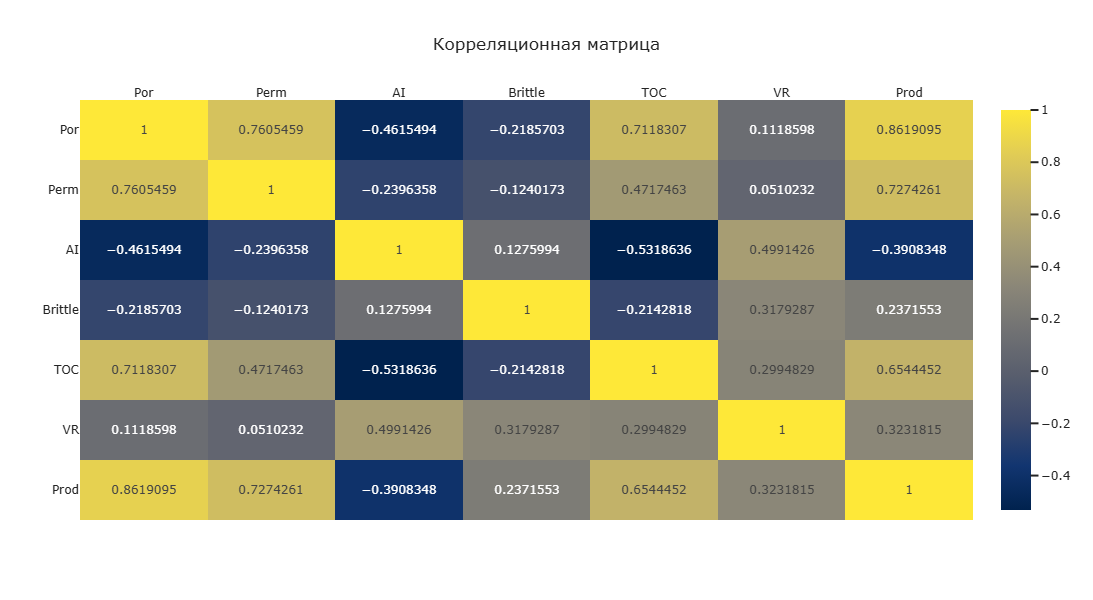

Ранг матрица: 7
Определитель матрицы: 0.00075


In [89]:
# Ваш код здесь
df = data.drop(['Well'], axis=1)
correlation = df.corr()
fig = px.imshow(img=correlation,
                title='Корреляционная матрица',
                origin='upper',
                height=600,
                width=600,
                template='seaborn',
                aspect='auto',
                color_continuous_scale='Cividis',
                text_auto=True)

fig.update_layout(showlegend=True)
fig.update_xaxes(side='top')
fig.show()

print(f'Ранг матрица: {np.linalg.matrix_rank(correlation)}')
print(f'Определитель матрицы: {np.round(np.linalg.det(correlation),5)}')

> *Ваши выводы здесь*
1. Какие факторы сильнее всего коррелируют с целевой переменной?\
Признак __'Por'__ (0.86) имеет <u>самую сильную корреляцию</u> с целевым признаком __'Prod'__, за ним идет __'Perm'__ (0.72) и __'TOC'__ (0.65)

2. Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?\
Да, матрица является плохо обусловенной, ее определитель близок к нулю из-за сильной корреляции между признаками

3. Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных?\
Присутствует высокая, но не полная мультиколлинеарность между признаками. Высокая корреляция может влиять на коэффициенты линейной регрессии

4. Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему?\
Формально - да, можно, т.к. ранг матрицы равен 7, как и количество неизвестных (признаков). Определитель так же, хоть и очень мал, но не равен нулю. Корреляция высокая, но не дотягивает до мультиколлинеарности.\
Но на практике, я бы еще доработал данные. Высокая корреляция будет искажать значения коэффициентов, так же могут возникать высокие стандартные ошибки.


### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> *Ваши выводы здесь*